# Importing Libraries

In [1]:
# table manipulation, calculating
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100) # increase the maximum number of columns

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# learning
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
import lightgbm as lgb

# Ignore all warnings
import warnings
warnings.simplefilter("ignore")

# Importing Datasets

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e4/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv')

In [3]:
df_train

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939


In [4]:
df_test

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,Mind & Body,Episode 100,21.05,Health,65.77,Saturday,Evening,96.40,3.0,Negative
249996,999996,Joke Junction,Episode 85,85.50,Comedy,41.47,Saturday,Night,30.52,2.0,Negative
249997,999997,Joke Junction,Episode 63,12.11,Comedy,25.92,Thursday,Evening,73.69,1.0,Neutral
249998,999998,Market Masters,Episode 46,113.46,Business,43.47,Friday,Night,93.59,3.0,Positive


# EDA

detail : 

# Preprocessing

In [5]:
# df_train
# Get the name of the categorical column
categorical_cols = df_train.select_dtypes(include=['object', 'category', 'bool']).columns

# Perform one-hot encoding on categorical columns and remove the original column
for col in categorical_cols:
    one_hot_encoded = pd.get_dummies(df_train[col], prefix=col, dtype=int)
    df_train = pd.concat([df_train, one_hot_encoded], axis=1)
    df_train = df_train.drop(col, axis=1)

In [6]:
# df_test
# Get the name of the categorical column
categorical_cols = df_test.select_dtypes(include=['object', 'category', 'bool']).columns

# Perform one-hot encoding on categorical columns and remove the original column
for col in categorical_cols:
    one_hot_encoded = pd.get_dummies(df_test[col], prefix=col, dtype=int)
    df_test = pd.concat([df_test, one_hot_encoded], axis=1)
    df_test = df_test.drop(col, axis=1)

# Feature Engineering

# Modeling

In [7]:
SEED = 42
NUM_SPLITS = 10 # try different folds

In [8]:
X = df_train.drop(columns=["id","Listening_Time_minutes"])
y = df_train["Listening_Time_minutes"]

In [9]:
# Hyperparameters of LightGBM (fixed values)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt', # Boosting type: Gradient Boosting Decision Tree
    'learning_rate': 0.01, # Learning rate: A smaller rate slows down learning but can improve accuracy
    'num_leaves': 30,  # Number of leaves in a decision tree: Set smaller to prevent overfitting
    'max_depth': 8,    # Maximum depth of a decision tree: Set smaller to prevent overfitting
    # 'feature_fraction': 0.7, # Fraction of features to sample: 0.7 means 70% of columns are used for learning
    # 'bagging_fraction': 0.7, # Fraction of data to sample: 0.7 means 70% of data is used for learning
    # 'bagging_freq': 1, # Frequency to apply bagging_fraction: 1 means apply at each iteration
    'lambda_l1': 0.1, # L1 regularization term weight: Prevents overfitting
    'lambda_l2': 0.1, # L2 regularization term weight: Prevents overfitting
    # 'min_child_samples': 20, # Minimum number of data needed in a leaf: Too small can cause overfitting
    # 'min_data_in_leaf': 40, # Minimum number of data needed in a leaf: Too small can cause overfitting
    # 'min_sum_hessian_in_leaf': 1e-2, # Minimum sum of hessians needed in a leaf: Too small can cause overfitting
    'verbosity': -1, # Level of logging output during learning: -1 means no output
    'early_stopping_rounds': 100, # Number of rounds for early stopping: Learning stops if the score doesn't improve for the specified rounds
    'random_state': SEED, # Random seed: Ensures reproducibility
    # 'colsample_bytree': 0.7, # Subsample ratio of columns when constructing each tree (prevents overfitting)
    # 'min_child_weight': 1e-3, # Minimum sum of instance weight (hessian) needed in a child (leaf)
    # 'path_smooth': 0.1, # Parameter to smooth decision tree path
    'max_bin': 255, # Maximum number of bins to bucket feature values
    'n_estimators': 100, # Number of boosting iterations (number of trees)
    # 'scale_pos_weight': 1, # Weight for balancing unbalanced classes
    # 'min_gain_to_split': 0.1, # Minimum loss reduction required to make a further partition on a leaf node
    #'feature_fraction_bynode': 0.8, # Fraction of features to consider for each node split
    #'force_col_wise': True, # Force column-wise histogram building
    #'extra_trees': True, # Enable random forest like behavior
    #'num_iterations': 2000, # Number of boosting iterations
    # 'drop_rate': 0.1, # Dropout rate for Dropout Boosting
    # 'skip_drop': 0.5, # Skip rate for Dropout Boosting
    # 'top_rate': 0.2, # Ratio of top instances to keep for GOSS
    # 'other_rate': 0.1, # Ratio of other instances to keep for GOSS
    #'categorical_feature': [0, 1, 2], # Indices of categorical features (add as needed)
    }

# K-Fold Cross-Validation
kf = KFold(n_splits=NUM_SPLITS, shuffle=True, random_state=SEED)
rmse_scores = []
models = []  # A list to store trained models

for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f"Fold {fold+1}")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(100, verbose=False)])

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    models.append(model)  # Save the trained model

# Show the mean and standard deviation of the cross-validation scores
print("\nCross-validation RMSE scores:", rmse_scores)
print(f"Mean RMSE: {np.mean(rmse_scores):.5f}")
print(f"Standard Deviation of RMSE: {np.std(rmse_scores):.5f}")

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10

Cross-validation RMSE scores: [15.836565541606701, 15.819810170342743, 15.840861559184281, 15.906836845404467, 15.85371691627219, 15.874450597141287, 15.84579970921399, 15.931489611233262, 15.748763605507659, 15.878261562477507]
Mean RMSE: 15.85366
Standard Deviation of RMSE: 0.04753


In [10]:
# Simple version of cross validation
# from sklearn.model_selection import cross_val_score

# # Preparing the LightGBM model (hyperparameters are defined in params)
# model = lgb.LGBMRegressor(**params)

# # Preparation for K-Fold cross-validation
# kf = KFold(n_splits=NUM_SPLITS, shuffle=True, random_state=SEED)

# # Evaluate RMSE using cross_val_score
# # By default, cross_val_score uses accuracy for classification and r2 for regression as the evaluation metric.
# # You need to explicitly specify negative_root_mean_squared_error in your scoring parameters and transform the results.
# neg_rmse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
# rmse_scores = -neg_rmse_scores

# print("Cross-validation RMSE scores:", rmse_scores)
# print(f"Mean RMSE: {np.mean(rmse_scores)}")

In [11]:
# # Visualize the distribution of RMSE scores with box plots
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=rmse_scores)
# plt.title('Distribution of RMSE Scores across Folds')
# plt.xlabel('Folds')
# plt.ylabel('RMSE Score')
# plt.xticks(range(1, NUM_SPLITS + 1))  # Fix X-axis label
# plt.grid(True)
# plt.show()

# # Scatter plot of predicted vs. actual values for each fold
# plt.figure(figsize=(8, 6))
# for fold, model in enumerate(models):
#     y_pred_val = model.predict(X.iloc[kf.split(X, y).__next__()[1]]) # Prediction of validation data for each fold
#     y_val = y.iloc[kf.split(X, y).__next__()[1]] # Actual values of validation data for each fold
#     plt.scatter(y_val, y_pred_val, label=f'Fold {fold+1}')

# # Diagonal (ideal prediction)
# min_val = min(y.min(), np.min([model.predict(X) for model in models]))
# max_val = max(y.max(), np.max([model.predict(X) for model in models]))
# plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray', label='Ideal Prediction')

# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Actual vs. Predicted Values across Folds')
# plt.legend()
# plt.grid(True)
# plt.show()

# # (Optional) Residual plots for each fold
# plt.figure(figsize=(8, 6))
# for fold, model in enumerate(models):
#     y_pred_val = model.predict(X.iloc[kf.split(X, y).__next__()[1]])
#     y_val = y.iloc[kf.split(X, y).__next__()[1]]
#     residuals = y_val - y_pred_val
#     plt.scatter(y_pred_val, residuals, label=f'Fold {fold+1}')

# plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals (Actual - Predicted)')
# plt.title('Residual Plot across Folds')
# plt.legend()
# plt.grid(True)
# plt.show()

# Select Features

## feature_importance

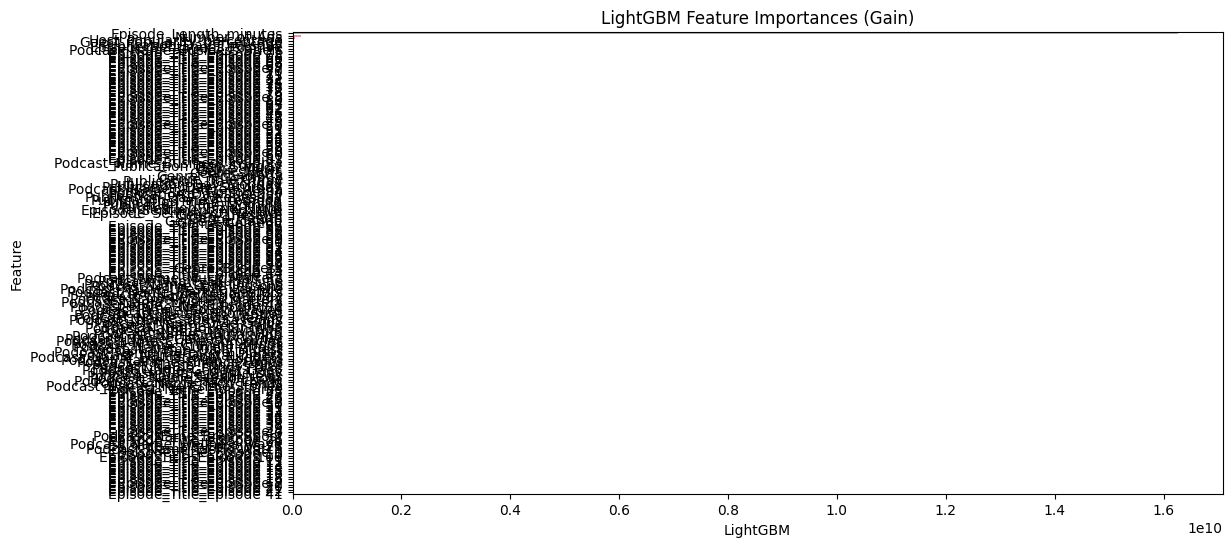

,Feature,LightGBM
0,Episode_Length_minutes,1.626962e+10
3,Number_of_Ads,1.566539e+08
1,Host_Popularity_percentage,4.162847e+07
2,Guest_Popularity_percentage,2.910743e+06
166,Publication_Day_Thursday,7.404624e+05
...,...,...
64,Episode_Title_Episode 2,0.000000e+00
65,Episode_Title_Episode 20,0.000000e+00
66,Episode_Title_Episode 21,0.000000e+00
67,Episode_Title_Episode 22,0.000000e+00


In [12]:
# Get the importance of features for each model using gain
lgb_importances = model.booster_.feature_importance(importance_type='gain')

# Get the name of the feature
feature_names = X.columns

# Summarize feature importance in a DataFrame
df_importances = pd.DataFrame({
    'Feature': feature_names,
    'LightGBM': lgb_importances,
})

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='LightGBM', y='Feature', data=df_importances.sort_values(by='LightGBM', ascending=False))
plt.title('LightGBM Feature Importances (Gain)')
plt.show()

display(df_importances.sort_values(by='LightGBM', ascending=False))

## SHAP

In [13]:
# import shap

# # LGBM SHAP values
# explainer_lgb = shap.TreeExplainer(model)
# shap_values_lgb = explainer_lgb.shap_values(X)

In [14]:
# shap.summary_plot(shap_values_lgb, X)

In [15]:
# # If shap_values_lgb is a list, convert it to a NumPy array
# if isinstance(shap_values_lgb, list):
#     shap_values_lgb = np.array(shap_values_lgb)

# # Handling the multiclass classification case
# if len(shap_values_lgb.shape) == 3:
#     shap_importance = np.abs(shap_values_lgb).mean(axis=1).mean(axis=0)
# # Handling binary classification cases
# else:
#     shap_importance = np.abs(shap_values_lgb).mean(axis=0)

# # Store in DataFrame
# df_importance = pd.DataFrame({
#     'feature': X.columns,
#     'shap_importance': shap_importance
# })

# # Sort by importance
# df_importance = df_importance.sort_values('shap_importance', ascending=False)

# # Show results
# display(df_importance

# Prediction

In [16]:
test_id = df_test["id"]
test = df_test.drop(columns=['id'])
submit_score = []

for fold_, model in enumerate(models):
    # predict test data
    pred_ = model.predict(test)
    submit_score.append(pred_)

# predict test data
pred = np.mean(submit_score, axis=0)

# Submission

In [17]:
submission = pd.DataFrame({
    'id': test_id,
    'Listening_Time_minutes': pred
})

# Save
submission.to_csv('submission.csv', index=False)

submission

,id,Listening_Time_minutes
0,750000,53.102914
1,750001,27.750085
2,750002,47.638028
3,750003,68.256762
4,750004,48.188497
...,...,...
249995,999995,24.371429
249996,999996,53.202731
249997,999997,21.001889
249998,999998,64.607810
